**Навигация по уроку**
1. [Семантическая сегментация изображений](https://colab.research.google.com/drive/10Zl8P7-YLFr9kXdjnvUuXDkruFBSFrlc)
2. [Практическая реализация модели сегментации](https://colab.research.google.com/drive/1yFPXLtKKTQcnOAy6JO3FYHdTbOAGtprR)
3. [Мультиклассовая сегментация](https://colab.research.google.com/drive/1Fy26vjAZPOVTOh8ZLnUYHiev3jD7J4Sh)
4. [Домашняя работа](https://colab.research.google.com/drive/1kJdyPBHBRWo2dXG0L9B1K8o4vfbQ2IQ8)

В домашней работе вам необходимо выполнить одно из трёх заданий на выбор:


**Задание 1. На 3 балла:**

1. Ваша задача используя модель и датасет из третей части урока, самостоятельно познакомиться с библиотекой [Albumentations](https://albumentations.ai/) и применить несколько методов аугментации для семантической сегментации снимков с беспилотника.

2. Используйте коллбэк функцию для предварительной остановки процесса обучения. Подумайте: какие параметры для остановки вы применили и почему?


**Задание 2. На 4 балла:**

1. Ваша задача зарегистрироваться на платформе по проведению соревнований в сфере машинного обучения [kaggle](https://www.kaggle.com/).
2. Загрузить датасет с данными о радиографическом ислледовании по COVID-19:

3. Обучить U-net подобную архитектуру сегментировать легкие человека на радиографическом снимке. Используйте данные о нормальном состоянии легких в папке `covid19-radiography-database/COVID-19_Radiography_Dataset/Normal`.

4. Отобразите по 10 снимков с оригинальным изображением, оригинальной маской и предсказанной маской.

**Задание 3. На 5 балла:**

1. Самостоятельно изучите модель [U-net++](https://arxiv.org/pdf/1807.10165.pdf). Найдите ее архитектуру, в интернете множество статей с готовой архитектурой на TensorFlow и Keras.
2. Выполните задание 2 для датасета с нормальным состоянием легких используя модель U-net++.


**Задание №3**

In [ ]:
!pip install opendatasets

In [ ]:
!pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.9/273.9 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 27.9 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.19
    Uninstalling albucore-0.0.19:
      Successfully uninstalled albucore-0.0.19
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20


In [ ]:
import opendatasets as op
op.download("https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: efanovnikita
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database


100%|██████████| 778M/778M [00:10<00:00, 81.0MB/s]


In [ ]:
import os

import matplotlib.pyplot as plt

import numpy as np

from keras.preprocessing.image import load_img
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU, Rescaling
from keras.layers import BatchNormalization, Conv2DTranspose, UpSampling2D, Concatenate
from keras.layers import Rescaling, Resizing
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical, Sequence
from keras.callbacks import ModelCheckpoint, EarlyStopping

import random

import albumentations as A

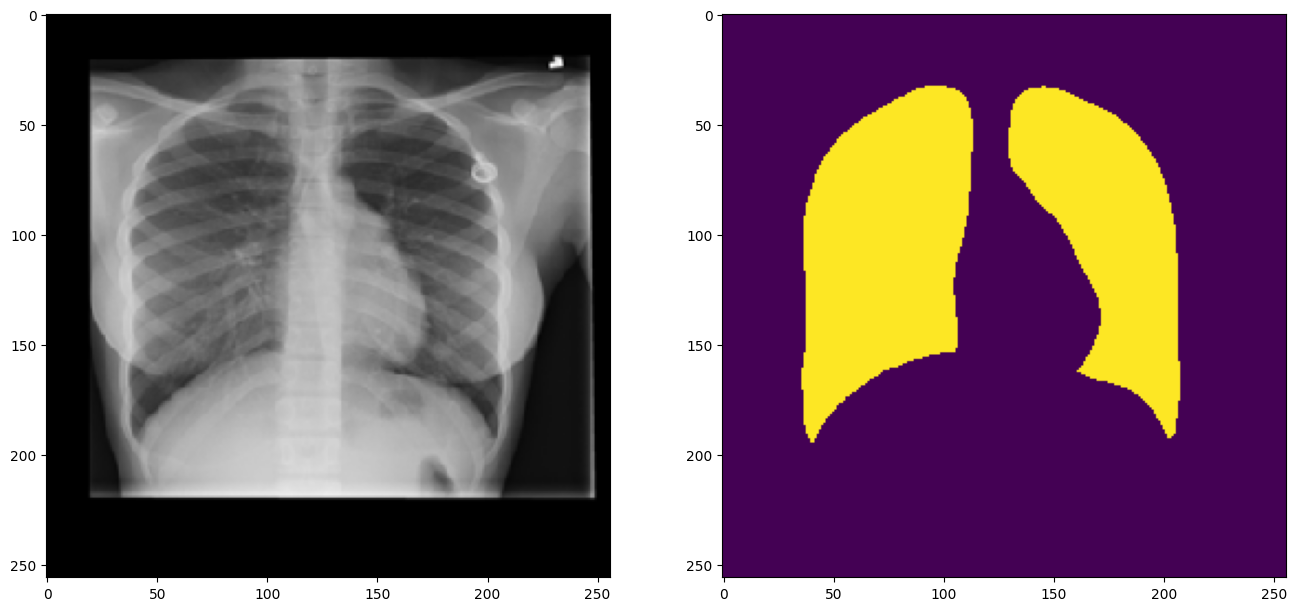

In [ ]:
img_path = 'covid19-radiography-database/COVID-19_Radiography_Dataset/Normal'
img = os.path.join(img_path, 'images/Normal-1.png')
mask = os.path.join(img_path, 'masks/Normal-1.png')

fig, axs = plt.subplots(1,2, figsize=(16,8))

img = np.array(load_img(img, target_size=(256, 256), color_mode='rgb'))
mask = np.array(load_img(mask, target_size=(256, 256), color_mode='grayscale'))

axs[0].imshow(img)
axs[0].grid(False)

axs[1].imshow(mask)
axs[1].grid(False)

In [ ]:
NUM_CLASSES = 2
IMG_SIZE = (128, 128)
batch_size = 8

class datasetGenerator(Sequence):

    def __init__(self, batch_size, img_size, input_img_path, target_img_path = None, num_classes = NUM_CLASSES, validation = False):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_path = input_img_path
        self.target_img_path = target_img_path
        self.validation = validation
        self.num_classes = num_classes

    def __len__(self):
        return len(self.target_img_path) // self.batch_size

    def __getitem__(self, idx):

        batch_input_img_path = self.input_img_path[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_target_img_path = self.target_img_path[idx*self.batch_size:(idx+1)*self.batch_size]

        x = np.zeros((self.batch_size, *self.img_size, 3), dtype='float32')
        y = np.zeros((self.batch_size, *self.img_size, self.num_classes), dtype='uint8')

        for _, paths in enumerate(zip(batch_input_img_path, batch_target_img_path)):
            img = np.array(load_img(paths[0], target_size=self.img_size, color_mode='rgb'))
            mask = np.array(load_img(paths[1], target_size=self.img_size, color_mode='grayscale'))

            if not self.validation:
                transform = A.Compose([
                    A.HorizontalFlip(p=0.5),
                    A.RandomRotate90(p=0.5)
                ])
                transformed = transform(image=img, mask=mask)
                img = transformed['image']
                mask = transformed['mask']

            x[_] = img / 255
            y[_] = to_categorical(mask / 255, num_classes=self.num_classes)

        return x, y

In [ ]:
input_img_path = [os.path.join(img_path, 'images', file_name) for file_name in os.listdir(os.path.join(img_path, 'images'))]
target_img_path = [os.path.join(img_path, 'masks', file_name) for file_name in os.listdir(os.path.join(img_path, 'masks'))]

In [ ]:
seed = 47

random.Random(seed).shuffle(input_img_path)
random.Random(seed).shuffle(target_img_path)

In [ ]:
val_samples = 1000

train_input_img_path = input_img_path[:-val_samples]
train_target_img_path = target_img_path[:-val_samples]
val_input_img_path = input_img_path[-val_samples:]
val_target_img_path = target_img_path[-val_samples:]

In [ ]:
train_gen = datasetGenerator(batch_size, img_size=IMG_SIZE, input_img_path=train_input_img_path, target_img_path=train_target_img_path)

val_gen = datasetGenerator(batch_size, img_size=IMG_SIZE, input_img_path=val_input_img_path, target_img_path=val_target_img_path, validation=True)

In [ ]:
def conv_block(inputs, num_filters):
    x = Sequential([
        Conv2D(num_filters, 3, padding='same'),
        BatchNormalization(),
        ReLU(),
        Conv2D(num_filters, 3, padding='same'),
        BatchNormalization(),
        ReLU()
    ])(inputs)

    return x

In [ ]:
# Архитектура Unet++

def unet_plus_plus_model(input_shape=(*IMG_SIZE, 3), num_classes=NUM_CLASSES):

    inputs = Input(shape=input_shape)

    # кодировщик
    x_00 = conv_block(inputs, 64)
    x_10 = conv_block(MaxPooling2D()(x_00), 128)
    x_20 = conv_block(MaxPooling2D()(x_10), 256)
    x_30 = conv_block(MaxPooling2D()(x_20), 512)
    x_40 = conv_block(MaxPooling2D()(x_30), 1024)

    # декодер
    x_01 = conv_block(Concatenate()([x_00, UpSampling2D()(x_10)]), 64)
    x_11 = conv_block(Concatenate()([x_10, UpSampling2D()(x_20)]), 128)
    x_21 = conv_block(Concatenate()([x_20, UpSampling2D()(x_30)]), 256)
    x_31 = conv_block(Concatenate()([x_30, UpSampling2D()(x_40)]), 512)

    x_02 = conv_block(Concatenate()([x_00, x_01, UpSampling2D()(x_11)]), 64)
    x_12 = conv_block(Concatenate()([x_10, x_11, UpSampling2D()(x_21)]), 128)
    x_22 = conv_block(Concatenate()([x_20, x_21, UpSampling2D()(x_31)]), 256)

    x_03 = conv_block(Concatenate()([x_00, x_01, x_02, UpSampling2D()(x_12)]), 64)
    x_13 = conv_block(Concatenate()([x_10, x_11, x_12, UpSampling2D()(x_22)]), 128)

    x_04 = conv_block(Concatenate()([x_00, x_01, x_02, x_03, UpSampling2D()(x_13)]), 64)

    outputs = Conv2D(num_classes, 1, padding='same', activation='softmax')(x_04)

    model = Model(inputs, outputs, name='unet_plus_plus')

    return model

In [ ]:
model = unet_plus_plus_model()

model.compile(
    optimizer='adam' ,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    ModelCheckpoint("segmentation.keras", monitor='val_loss', save_best_only=True),
    EarlyStopping(monitor="val_loss", min_delta=0.005, patience=5, restore_best_weights=True)
]

In [ ]:
epochs = 20
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=callbacks
                   )

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1149/1149 ━━━━━━━━━━━━━━━━━━━━ 482s 348ms/step - accuracy: 0.9642 - loss: 0.0900 - val_accuracy: 0.9899 - val_loss: 0.0250
Epoch 2/20
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 455s 359ms/step - accuracy: 0.9898 - loss: 0.0258 - val_accuracy: 0.9917 - val_loss: 0.0196
Epoch 3/20
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 395s 343ms/step - accuracy: 0.9915 - loss: 0.0211 - val_accuracy: 0.7511 - val_loss: 1.9700
Epoch 4/20
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 406s 353ms/step - accuracy: 0.9916 - loss: 0.0213 - val_accuracy: 0.9947 - val_loss: 0.0129
Epoch 5/20
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 406s 353ms/step - accuracy: 0.9934 - loss: 0.0166 - val_accuracy: 0.9947 - val_loss: 0.0126
Epoch 6/20
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 395s 343ms/step - accuracy: 0.9938 - loss: 0.0156 - val_accuracy: 0.9870 - val_loss: 0.0387
Epoch 7/20
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 448s 349ms/step - accuracy: 0.9934 - loss: 0.0164 - val_accuracy: 0.9949 - val_loss: 0.0120
Epoch 8/20
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 444s 351ms/step - accuracy: 0.9

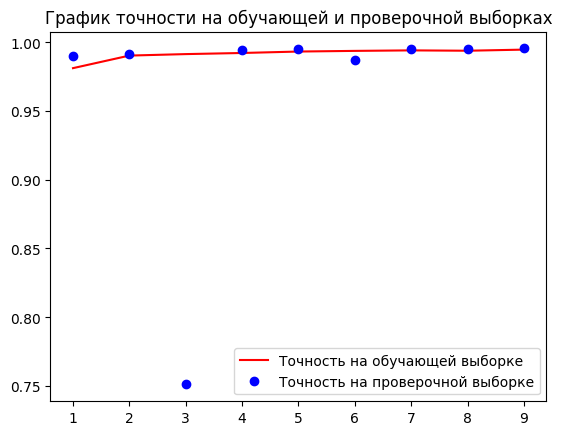

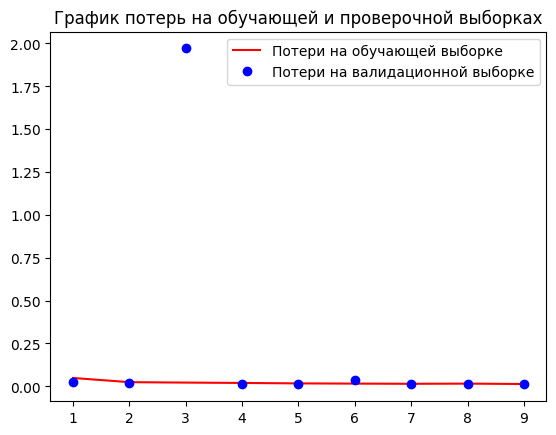

In [ ]:
acc = history.history['accuracy']                              # данные о точности на обучающей выборке
val_acc = history.history['val_accuracy']                      # данные о точности на проверочной выборке
loss = history.history['loss']                                             # данные об ошибке на обучающей выборке
val_loss = history.history['val_loss']                                     # данные об ошибке на проверочной выборке
epochs = range(1, len(acc) + 1)                                            # массив со значениями для оси абсцисс (Х)
plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')          #  строим график точность на обучающей выборке
plt.plot(epochs, val_acc, 'bo', label='Точность на проверочной выборке')   #  строим график точность на проверочной выборке
plt.title('График точности на обучающей и проверочной выборках')           #  заголовок графика
plt.legend()                                                               #  легенда графика
plt.figure()                                                               #  создаем новую фигуру (полотно для графика)
plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')           #  строим график потерь (ошибки) на обучающей выборке
plt.plot(epochs, val_loss, 'bo', label='Потери на валидационной выборке')  #  строим график потерь на проверочной выборке
plt.title('График потерь на обучающей и проверочной выборках')             #  заголовок графика
plt.legend()                                                               #  легенда графика
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


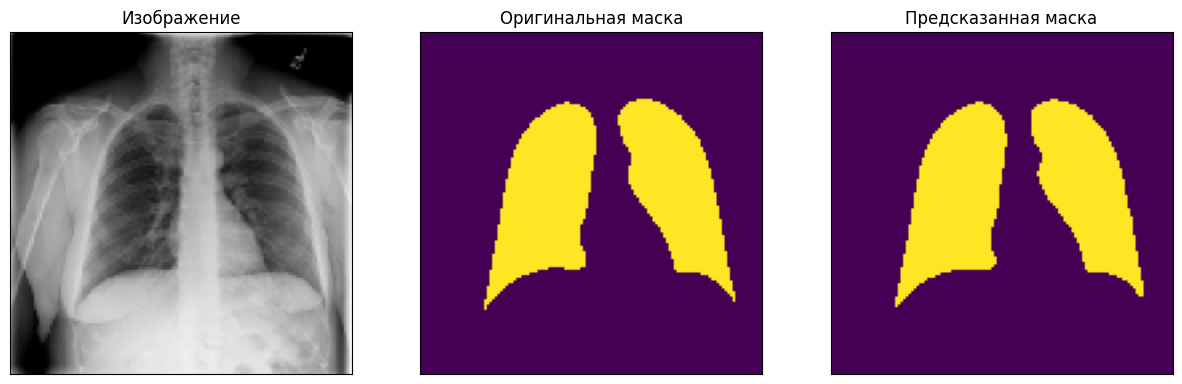

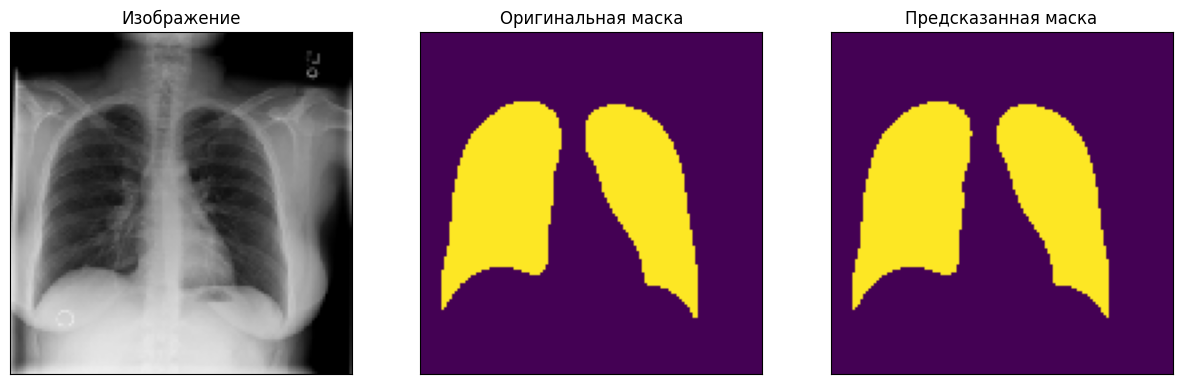

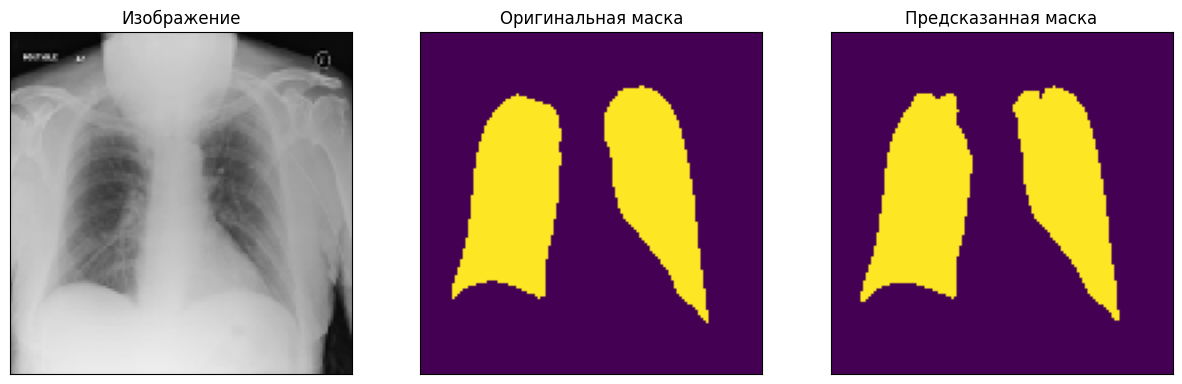

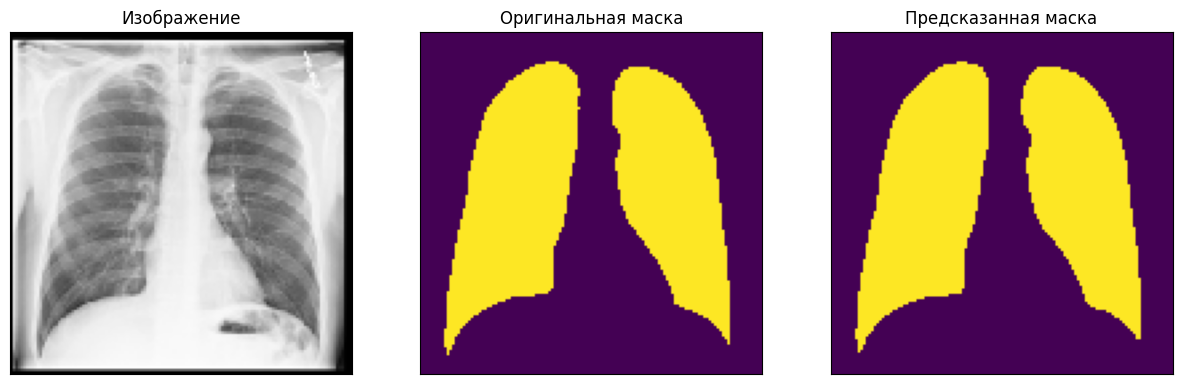

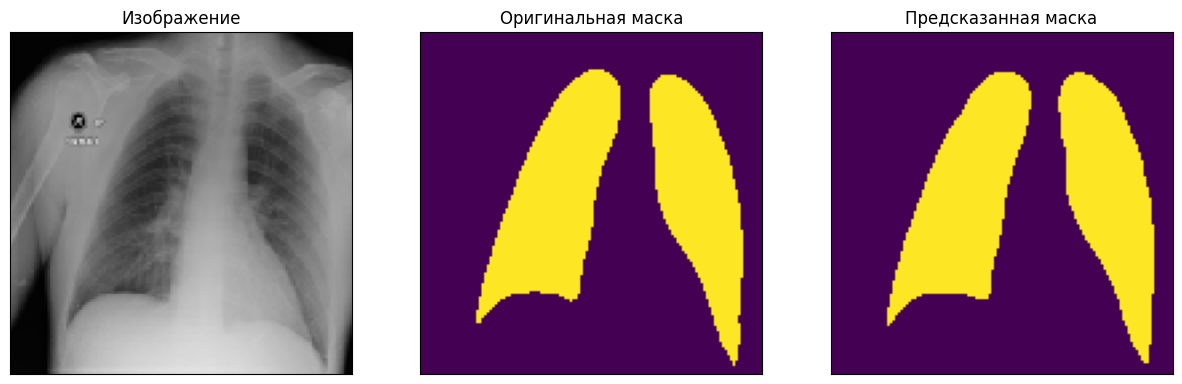

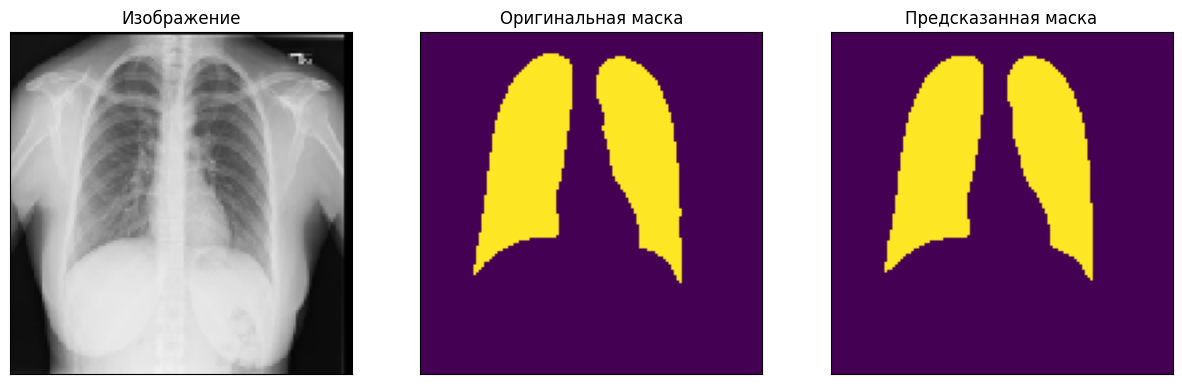

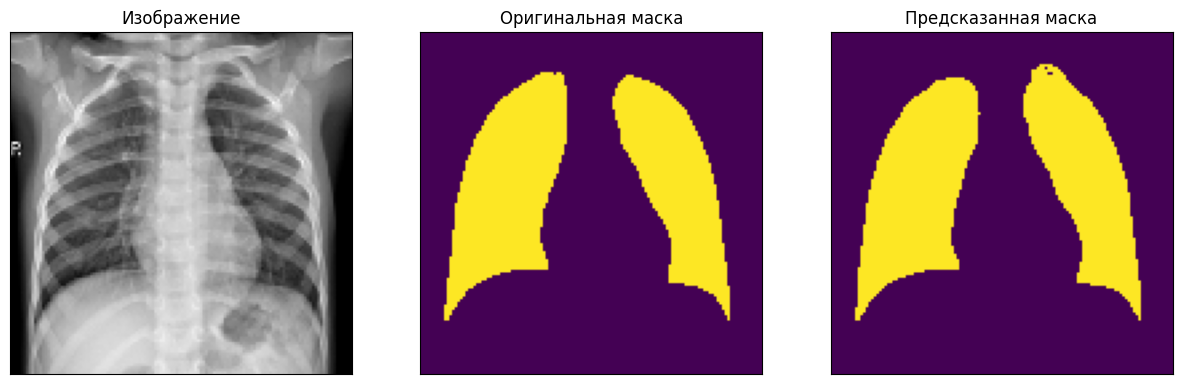

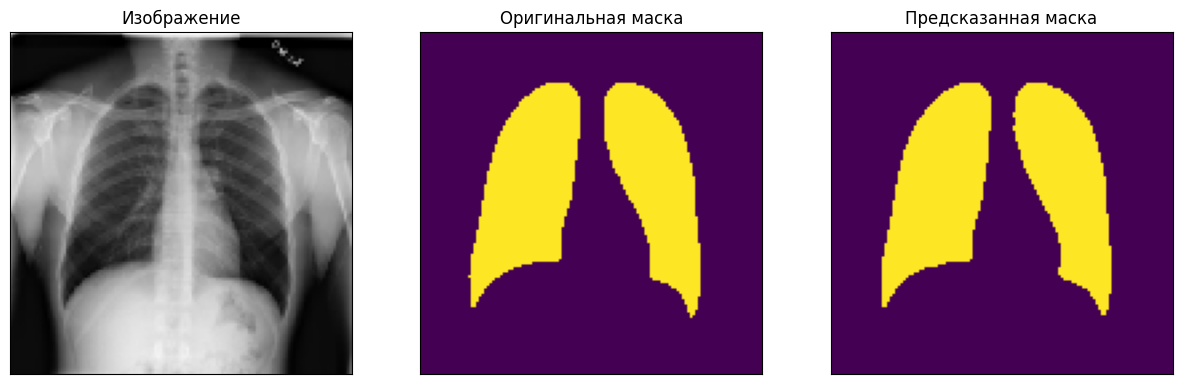

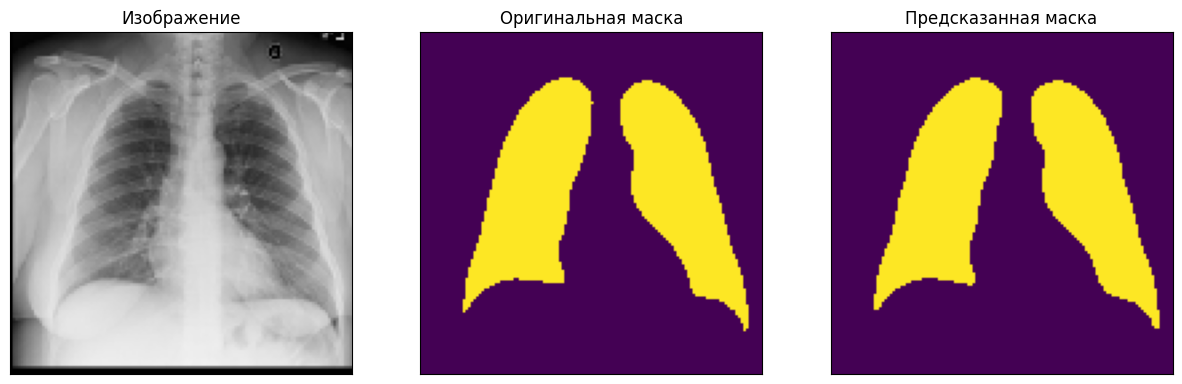

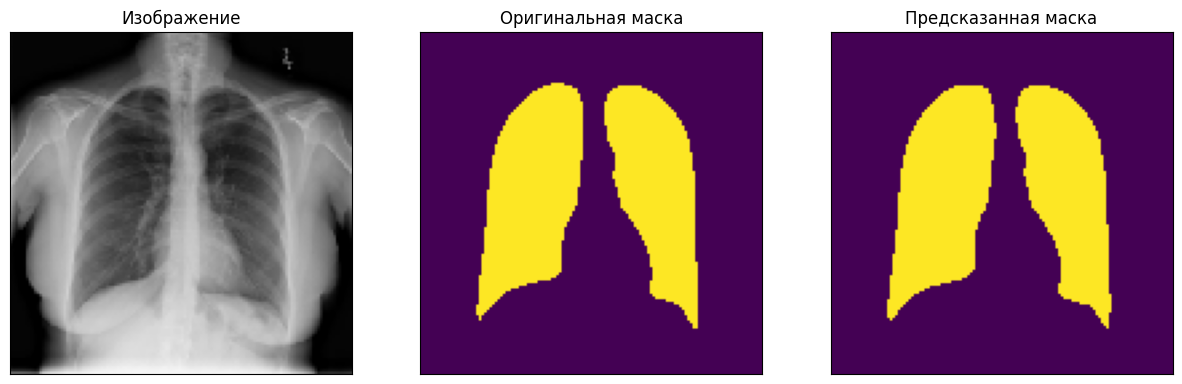

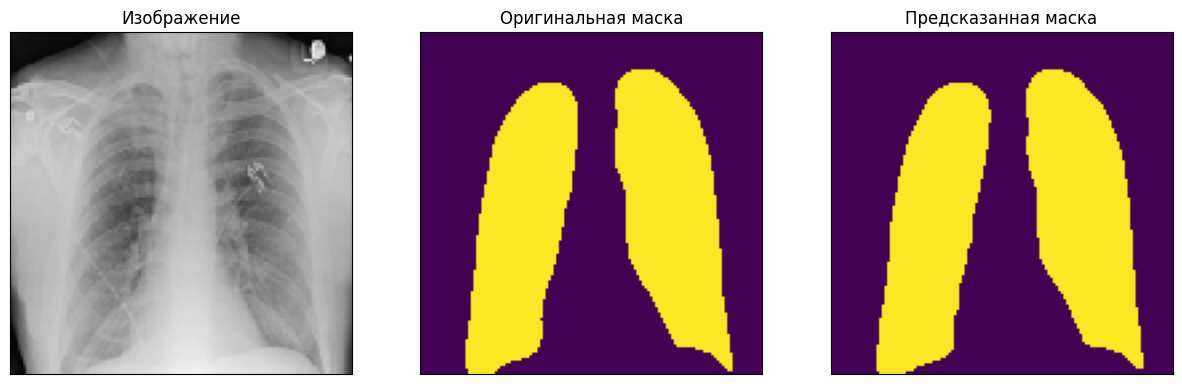

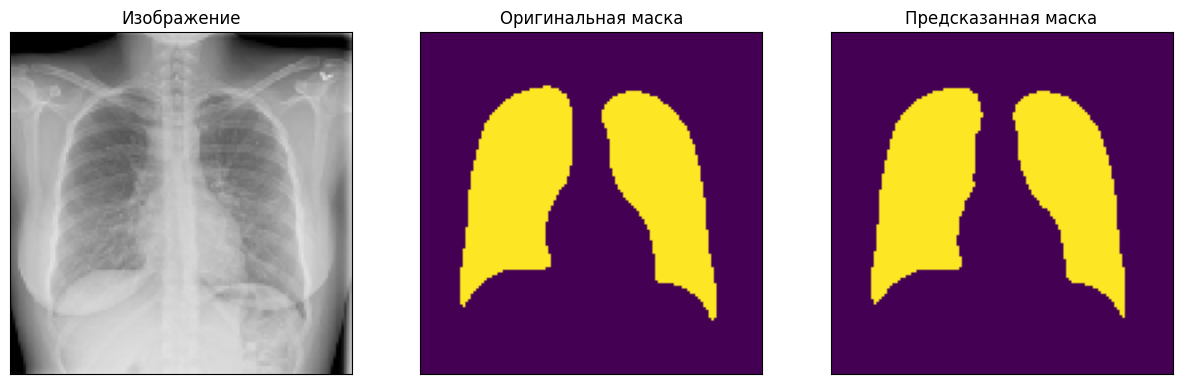

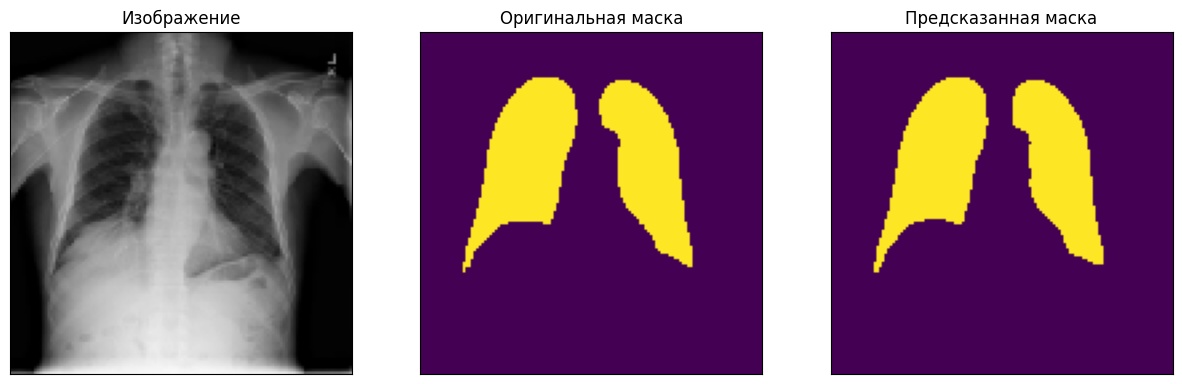

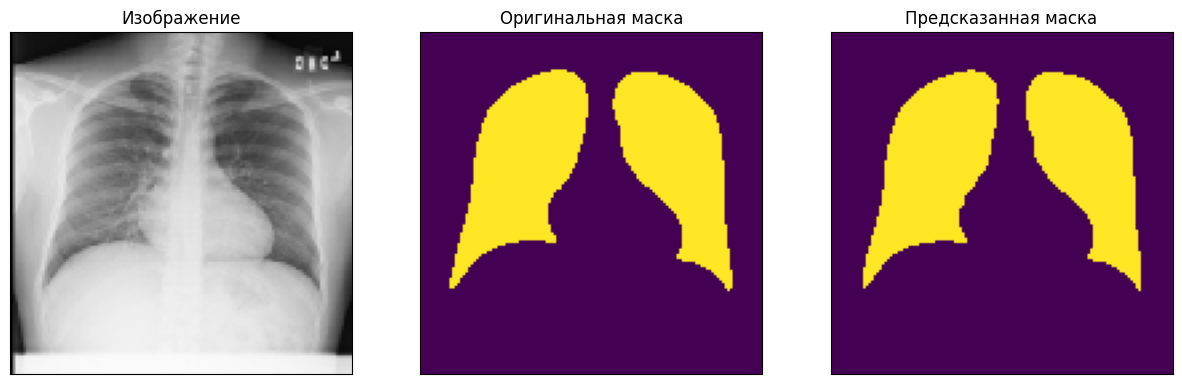

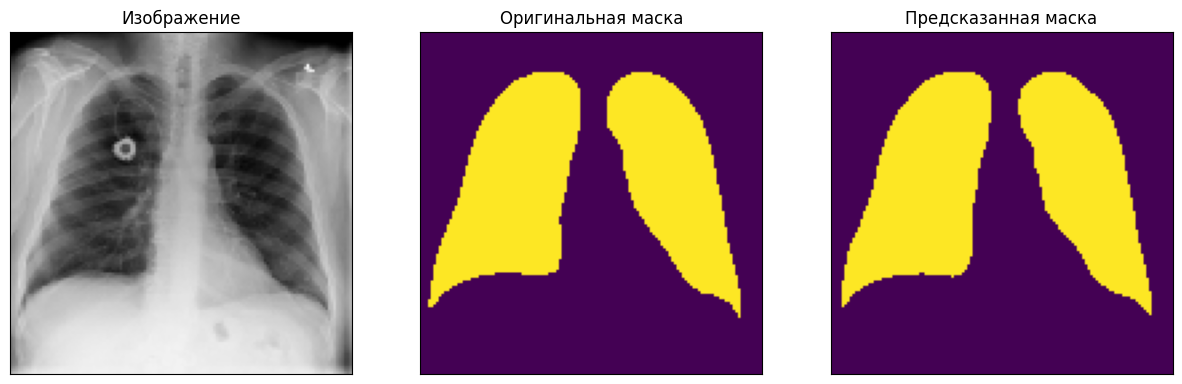

In [ ]:
for i in range(15):
    img = np.array(load_img(val_input_img_path[i], target_size=IMG_SIZE, color_mode='rgb'))
    mask = np.array(load_img(val_target_img_path[i], target_size=IMG_SIZE, color_mode='grayscale'))

    test = model.predict(np.expand_dims(img, 0) / 255)

    test = np.argmax(test, axis=-1)

    fig, axs = plt.subplots(1, 3, figsize=(15,15), subplot_kw=dict(xticks=([]), yticks=([])))
    axs[0].set_title('Изображение')
    axs[0].imshow(img)
    axs[1].set_title('Оригинальная маска')
    axs[1].imshow(mask)
    axs[2].set_title('Предсказанная маска')
    axs[2].imshow(test[0])